## Understanding generalization ##

<img src = 'fepzup.png', width = 450px>

Given these labelled examples, how should be generalize to the striped circle?

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn import neural_network
from sklearn import gaussian_process
import sklearn.gaussian_process.kernels as gpk
from sklearn.base import clone
import pandas as pd
from matplotlib.transforms import Bbox

def soft_sign(x):
    s = sigma(x)
    return 2*s - 1.0

def sigma(x):
    return 1.0 / (1.0 + np.exp(-x))



In [2]:
# define all classifier models

kernel_dict = {'lin': gpk.DotProduct(),
           'quad': gpk.Exponentiation(gpk.DotProduct(), exponent=2),
           'cube': gpk.Exponentiation(gpk.DotProduct(), exponent=3),
           'gauss': gpk.RBF()
          }

gp_clfs = [(gaussian_process.GaussianProcessClassifier(kernel = k, max_iter_predict = 20), n+'_kernel')
           for n, k in kernel_dict.items()]

all_clfs = [
    (linear_model.LogisticRegression(), 'logreg'),
    (neural_network.MLPClassifier(hidden_layer_sizes = (2,), 
                                 activation = 'relu',
                                 max_iter=2000), 'MLP_2H_1L'),
    (neural_network.MLPClassifier(hidden_layer_sizes = (5,), 
                                 activation = 'relu',
                                 max_iter=2000), 'MLP_5H_1L')
            ] + gp_clfs



# gp_clfs = [(gaussian_process.GaussianProcessClassifier(), k) for k in kernel_dict.keys()]

# all_clfs = [
#     linear_model.LogisticRegression(),
#     neural_network.MLPClassifier(hidden_layer_sizes = (2,), 
#                                  activation = 'relu'), 
#     neural_network.MLPClassifier(hidden_layer_sizes = (5,), 
#                                  activation = 'relu')
#             ] + gp_clfs



In [3]:
exp_dict = {
    0: 'conflict',
    1: 'zero_shot',
    2: 'partial_exposure'
}

def get_data(
    x_offset_abs: float = 3.0,
    y_offset_abs: float = 3.0,
    num_datapoints: int = 100,
    center_value: float = 0.0,
    rotate: bool = False):
    
    print("Getting new data")

    inf_dim = 0
    distractor_dim = 1

    test_true_label = 1
    test_distractor_label = 1
    
    rotation_matrix = np.array([1, -1, 1, 1]).reshape((2, 2))/ np.sqrt(2)

    # generate data
    data_list = []
    for x in [-x_offset_abs, x_offset_abs]:
        for y in [-y_offset_abs, y_offset_abs]:
            center = center_value + np.array([x, y])[None, :]
            data_list.append(
              center
              + np.reshape(np.random.normal(size=num_datapoints * 2), (-1, 2))
            )

    data = np.concatenate(data_list, axis=0)
    
    extra_feature = data[:, 0]*data[:, 1]
#     print(f'extra feature: mean = {np.mean(extra_feature)}, sd = {np.sqrt(np.var(extra_feature))}')

    # classify the data
    true_label = (data[:, inf_dim] > center_value).astype("int")

    # track confounder values
    distractor_label = (data[:, distractor_dim] > center_value).astype("int")

    # denote labels by whether they are same as test set or not
    true_label_eq2test = true_label == test_true_label
    distractor_label_eq2test = distractor_label == test_distractor_label

    mask = np.logical_and(true_label_eq2test, distractor_label_eq2test)
    test_x, test_y = data[mask], true_label[mask]
    if rotate: 
        test_x = np.matmul(test_x, rotation_matrix)

    # the train set depends on the experiment
    mask_zr_sht = np.logical_not(distractor_label_eq2test)

    mask_cnflt = np.logical_xor(true_label_eq2test, distractor_label_eq2test)


    balance = True
    if balance:
        # balance data across informative dimension

        # include all data with same true label as test but different distractor
        mask1 = np.logical_and(
          true_label_eq2test, np.logical_not(distractor_label_eq2test)
        )

        # include half of others
        mask2 = np.logical_and(
          np.logical_not(true_label_eq2test),
          np.random.uniform(size=4 * num_datapoints) > 0.5,
        )
        
        mask_prtl_xpsr = np.logical_or(mask1, mask2)
        
#         # allow some mixing of test into train = data won't be balanced
#         ratio = 0.95
#         mask_incl_from_test = np.logical_and(
#               np.logical_and(true_label_eq2test, distractor_label_eq2test),
#               np.random.uniform(size=4 * num_datapoints) > ratio,
#             )
        
#         mask_prtl_xpsr = np.logical_or(mask_prtl_xpsr, mask_incl_from_test)
        
    else:
        mask_prtl_xpsr = np.logical_not(
              np.logical_and(true_label_eq2test, distractor_label_eq2test)
            )

    datas = []
    
    
    for mask in [mask_cnflt, mask_zr_sht, mask_prtl_xpsr]:
        
        
        train_x0, train_y0 = data[mask], true_label[mask]
    
        shuffle = np.random.permutation(len(train_y0))

        train_x, train_y = train_x0[shuffle], train_y0[shuffle]
        
        if rotate:
            train_x = np.matmul(train_x, rotation_matrix)

        ds = {
          "train": {'inp': train_x,
                    'label': train_y},
          "test": {'inp': test_x,
                   'label': test_y}
        }
        datas.append(ds)
        
    return datas
        
        

In [45]:
plt_size = 7
norm_extra_feat = 3.0

def get_feats(x, clf_name):
    Nfeats = 2
    if 'PROD' in clf_name:
        extra_feature = x[:, 0]*x[:, 1]/norm_extra_feat
        x = np.concatenate((x, extra_feature[:, None]), axis = 1)
        Nfeats = 3 
    
    return x, Nfeats
    

# def norm_feats(x):
#     vals = []
#     for x_val in x.T:
#         vals.append((x_val - np.mean(x_val)/ np.sqrt(np.var(x_val))))
        
#     x = np.array(vals).T
#     return np.array(vals).T

def classify_data(data, clf, clf_name):
    x, Nfeats = get_feats(data['inp'], clf_name)
    joint = list(zip(x, data['label']))
    np.random.shuffle(joint)
    x, y = zip(*joint)

    clf.fit(x,y)

    xx = np.linspace(-plt_size, plt_size, num = 100)
    l_x = xx.shape[0]
    X, Y = np.meshgrid(xx, xx)
    inp = np.concatenate((X[:, :, None], Y[:,:, None]), axis = 2)
    if 'PROD' in clf_name:
        inp = np.concatenate((inp, X[:, :, None]*Y[:,:, None]/norm_extra_feat), axis = 2)
    pred = clf.predict(inp.reshape((-1, Nfeats))).reshape(l_x, l_x)
    
#     pred = (inp.reshape((-1, 2))[:, 1] < 0).reshape(l_x, l_x)

    return clf, pred

# green = (68,170,153), #44AA99
# purple = (170,68,153) #AA4499
# mid = #777799

def full_extent(ax, pad=0.0):
    """Get the full extent of an axes, including axes labels, tick labels, and
    titles."""
    # For text objects, we need to draw the figure first, otherwise the extents
    # are undefined.
    ax.figure.canvas.draw()
#     items = ax.get_xticklabels() + ax.get_yticklabels() 
#    items += [ax, ax.title, ax.xaxis.label, ax.yaxis.label]
    items = [ax]#, ax.title]
    bbox = Bbox.union([item.get_window_extent() for item in items])

    return bbox.expanded(1.0 + pad, 1.0 + pad)

def plot(ax, data, pred, name, plot_points = False):
    #test_true_label set to 1 above
    feps = data['train']['inp'][data['train']['label'] == 0]
    blickets = data['train']['inp'][data['train']['label'] == 1]
    
    xx = np.linspace(-plt_size, plt_size, num = 100)
    X, Y = np.meshgrid(xx, xx)

    
    if ax: 
        alpha = 0.03
        
#         cs = pyplot.contourf(x,y,z,levels=np.arange(50, 220, 20), cmap=pyplot.cm.jet, extend="both")
# cs.cmap.set_under('k')
# cs.set_clim(50, 210)
# cb = pyplot.colorbar(cs)

        ax.contourf(X, Y, 1.0 - pred, levels = [0.0, 0.5, 1.1], colors = ['#44AA99', '#AA4499', '#AA4499'], alpha = alpha)
        if plot_points: 
            ax.scatter(data['test']['inp'][:, 0], data['test']['inp'][:, 1], 
                   s = 8, facecolors = 'white')#, label = 'Test blickets' if legend else None) 
            ax.scatter(feps[:, 0], feps[:, 1], 
                   s = 8, facecolors = '#AA4499')#, label = 'Train feps' if legend else None)
            ax.scatter(blickets[:, 0], blickets[:, 1], 
                   s = 8, facecolors = '#44AA99')#, label = 'Train blickets' if legend else None)
#         ax.set_xticks(np.arange(-plt_size, plt_size+1, step=plt_size/2))
#         ax.set_yticks(np.arange(-plt_size, plt_size+1, step=plt_size/2))
#         ax.set_title(name)
        ax.axis('off')
        ax.set_xlim([-plt_size, plt_size])
        ax.set_ylim([-plt_size, plt_size])
#         if legend: ax.legend()

        
    return ax



    
def bar_results(means, stds, ax):
    
    ax.bar(np.arange(len(means)) + 1, means, yerr = stds)
    ax.set_ylim([-0.1, 1.1])
    
    return ax
    

In [46]:
def run_analyses(reps = 10, clfs = None, resample_data = False, fname = None, rotate = False, makefig = True):
    if not clfs: clfs = [(linear_model.RidgeClassifier(), 'logreg'), 
                         (linear_model.LogisticRegression(), 'ridgereg')]
    

    datas = get_data(rotate = rotate)
    if fname is None: fname = str(int(np.random.uniform()*100000))

    fig, axes = plt.subplots(len(clfs), len(datas))
    fig.set_size_inches(4*(len(datas)), 4*len(clfs))
    cols = ['seed', 'expt', 'classifier', 'train_perf', 'test_perf']
    perf_df = pd.DataFrame(columns = cols)
    with open(fname + '.csv', 'w') as f:
        f.write(', '.join(cols) + '\n')
    counter = 0
    for j, clf_tuple in enumerate(clfs):
        clf, clf_name = clf_tuple
        for i in np.arange(reps):
            verbose = not i
            print('copy:', i)
            if resample_data:
                datas = get_data(rotate = rotate)
            for k, data in enumerate(datas): 


#                 # GP gives the same results everytime, can only run once, except if we resample data
#                 if ((perf_df[perf_df['classifier'] == clf_name]['expt'].str.contains(exp_dict[k]).sum()) and 
#                     (perf_df['classifier'].str.contains(clf_name).sum()) and 
# #                     ('kernel' in clf_name) and 
#                     (not resample_data)):
                    
#                     if verbose: print('Skipping GP because done')
#                     continue
                    
                if verbose: print(i, clf, exp_dict[k])
                cond_perf = []

                c, pred = classify_data(data['train'], clf = clone(clf), clf_name = clf_name)
                train_feats, _ = get_feats(data['train']['inp'], clf_name)
                train_perf = np.mean(c.predict(train_feats) == data['train']['label'])
                test_feats, _ = get_feats(data['test']['inp'], clf_name)
                test_perf = np.mean(c.predict(test_feats) == data['test']['label'])
                
                print(test_perf)
                if train_perf > 0.95 and makefig:
                    axes[j, k] = plot(axes[j, k], data, pred, 
                                      name = clf_name + " " + exp_dict[k], 
                                      plot_points = i == reps - 1)
                row = [
                    i, 
                    exp_dict[k], 
                    clf_name, 
                    train_perf,
                    test_perf
                ]
                perf_df.loc[counter] = row
                with open(fname + '.csv', 'a') as f:
                    row = [str(x) for x in row]
                    f.write(', '.join(row) + '\n')
                counter += 1
            


        
                
    # eliminate those that don't get good train perf
    perf_df = perf_df[perf_df['train_perf'] > 0.95]
    summ = perf_df.groupby(['expt', 'classifier']).agg(['mean', 'sem']).reset_index()
    summ.columns = ['_'.join(col).strip() for col in summ.columns.values]
    
    if makefig:
        for j, clf_tuple in enumerate(clfs):
            clf, clf_name = clf_tuple
            for k, _ in enumerate(datas):
                extent = full_extent(axes[j, k]).transformed(fig.dpi_scale_trans.inverted())
                fig.savefig(clf_name + "" + exp_dict[k] + '.pdf', bbox_inches=extent)

#     print(summ)
    
#     for i, clf_tuple in enumerate(clfs):
#         s = summ[summ['classifier_'] == clf_tuple[1]]
#         axes[i, -1] = bar_results(s['test_perf_mean'], 1.96*s['test_perf_sem'],  axes[i, -1])



#     if passed :
#         m_perf = np.mean(perfs[train_perf_pass], axis = 0)
#         ci_perf = 1.96*np.std(perfs[train_perf_pass], axis = 0)/np.sqrt(reps)
#         axes[-1, -1] = bar_results(m_perf[-1], ci_perf[-1],  axes[-1, -1])


    fig.tight_layout()
    if makefig:
        plt.savefig(fname + '.png')
        plt.savefig(fname + '.svg')
        plt.savefig(fname + '.pdf')
    plt.show()
    return perf_df, (fig, axes)


In [47]:
# # with resampling data

# clfs = [
#     (gaussian_process.GaussianProcessClassifier(kernel = kernel_dict['quad'],
#                                                max_iter_predict = 20), 'quad_kernel'),
    
#     (gaussian_process.GaussianProcessClassifier(kernel = kernel_dict['cube'],
#                                                max_iter_predict = 20), 'cube_kernel')
#             ]

# d = run_analyses(reps = 10, clfs = clfs, fname = 'withresample.csv')

In [48]:
# without resampling data
# for plots

clfs = [
    (linear_model.LogisticRegression(solver = 'liblinear'), 'logreg'),
    (gaussian_process.GaussianProcessClassifier(kernel = kernel_dict['gauss'],
                                               max_iter_predict = 20), 'gauss_kernel'),
    
    
    (neural_network.MLPClassifier(hidden_layer_sizes = (5,), 
                                 activation = 'relu',
                                 max_iter=2000), 'MLP_5H_1L')
 ]
    

In [32]:
# # without resampling data
# # for plots

# clfs = [
#     (linear_model.LogisticRegression(solver = 'liblinear'), 'logreg'),

#     (linear_model.LogisticRegression(solver = 'lbfgs', penalty = 'none'), 'logreg_PROD_none'),  
#     (linear_model.LogisticRegression(solver = 'liblinear', penalty = 'l2'), 'logreg_PROD_l2'),  
#     (linear_model.LogisticRegression(solver = 'liblinear', penalty = 'l1'), 'logreg_PROD_l1'),  
# #     (linear_model.LogisticRegression(solver = 'liblinear', penalty = 'l2', C = 0.5), 'logreg_PROD_l2_high'),  
# #     (linear_model.LogisticRegression(solver = 'liblinear', penalty = 'l1', C = 0.5), 'logreg_PROD_l1_high'),  
    
# #     (gaussian_process.GaussianProcessClassifier(kernel = kernel_dict['gauss'],
# #                                                max_iter_predict = 20), 'gauss_kernel'),
    
    
# #     (neural_network.MLPClassifier(hidden_layer_sizes = (5,), 
# #                                  activation = 'relu',
# #                                  max_iter=2000), 'MLP_5H_1L')
#  ]
    

Getting new data
copy: 0
0 LogisticRegression(solver='liblinear') conflict
0.56
0 LogisticRegression(solver='liblinear') zero_shot
1.0
0 LogisticRegression(solver='liblinear') partial_exposure
1.0
copy: 1
0.56
1.0
1.0
copy: 2
0.56
1.0
1.0
copy: 3
0.56
1.0
1.0
copy: 4
0.56
1.0
1.0
copy: 5
0.56
1.0
1.0
copy: 6
0.56
1.0
1.0
copy: 7
0.56
1.0
1.0
copy: 8
0.56
1.0
1.0
copy: 9
0.56
1.0
1.0
copy: 10
0.56
1.0
1.0
copy: 11
0.56
1.0
1.0
copy: 12
0.56
1.0
1.0
copy: 13
0.56
1.0
1.0
copy: 14
0.56
1.0
1.0
copy: 15
0.56
1.0
1.0
copy: 16
0.56
1.0
1.0
copy: 17
0.56
1.0
1.0
copy: 18
0.56
1.0
1.0
copy: 19
0.56
1.0
1.0
copy: 20
0.56
1.0
1.0
copy: 21
0.56
1.0
1.0
copy: 22
0.56
1.0
1.0
copy: 23
0.56
1.0
1.0
copy: 24
0.56
1.0
1.0
copy: 25
0.56
1.0
1.0
copy: 26
0.56
1.0
1.0
copy: 27
0.56
1.0
1.0
copy: 28
0.56
1.0
1.0
copy: 29
0.56
1.0
1.0
copy: 0
0 GaussianProcessClassifier(kernel=RBF(length_scale=1), max_iter_predict=20) conflict
0.51
0 GaussianProcessClassifier(kernel=RBF(length_scale=1), max_iter_predict=20

/Users/ishita/anaconda/envs/exposure-bias/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


0.96
0.93
copy: 12
0.97
0.98
0.01
copy: 13
0.15
0.97
0.7
copy: 14
0.46
0.1
0.76
copy: 15
0.17
1.0
0.95
copy: 16
0.47
1.0
0.96
copy: 17


/Users/ishita/anaconda/envs/exposure-bias/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


0.62
1.0
0.01
copy: 18
0.1
1.0
0.94
copy: 19
0.91
1.0
0.49
copy: 20
0.9
1.0
0.82
copy: 21
0.67
1.0
1.0
copy: 22
0.35
0.82
0.29
copy: 23
0.38
0.04
0.63
copy: 24
0.54
1.0
0.84
copy: 25
0.49
1.0
0.09
copy: 26
0.93
0.98
0.98
copy: 27
0.26
1.0
1.0
copy: 28
0.66
0.97
1.0
copy: 29
0.95
0.98
0.77


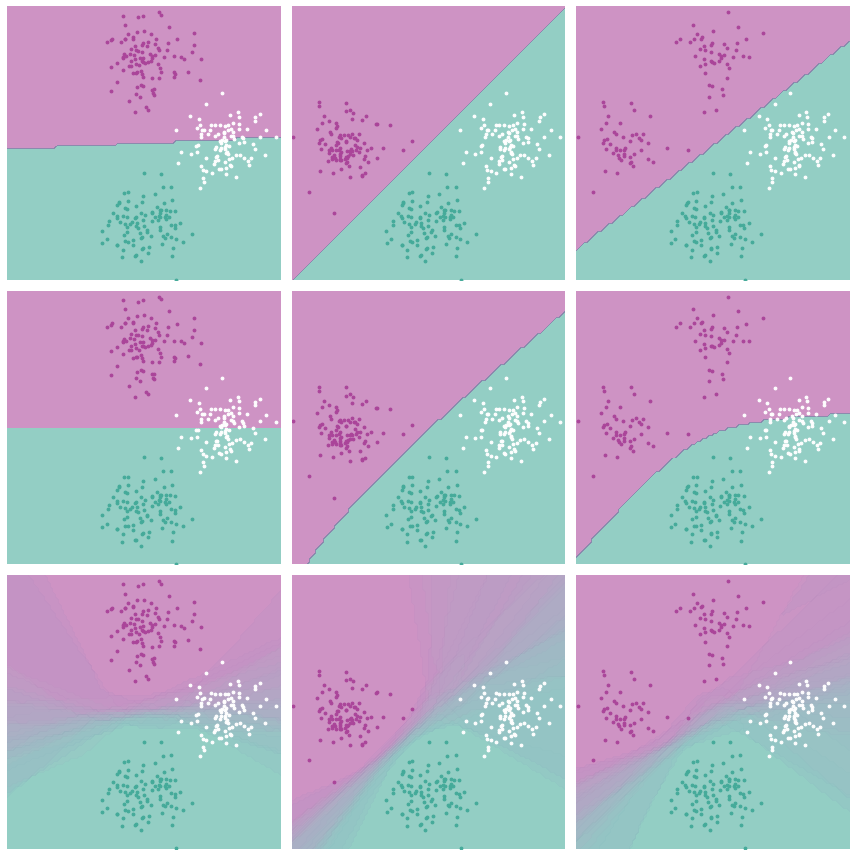

In [50]:
d, f = run_analyses(reps = 30, clfs = clfs, resample_data = False, makefig = True, rotate = True, fname = 'NN_misaligned')
# get_data(num_datapoints = 2)

In [18]:
# d, f = run_analyses(reps = 30, clfs = clfs, fname = 'axis_aligned_plot_runs')
# d, f = run_analyses(reps = 30, clfs = clfs, fname = 'axis_misaligned_plot_runs', rotate = True)

In [19]:
# # without resampling data

# clfs = [
#     (linear_model.LogisticRegression(), 'logreg'),
    
#     (neural_network.MLPClassifier(hidden_layer_sizes = (1,), 
#                                  activation = 'relu',
#                                   max_iter=2000), 'MLP_1H_1L'),
    
#     (neural_network.MLPClassifier(hidden_layer_sizes = (2,), 
#                                  activation = 'relu',
#                                  max_iter=2000), 'MLP_2H_1L'),
    
#     (neural_network.MLPClassifier(hidden_layer_sizes = (3,), 
#                                  activation = 'relu',
#                                  max_iter=2000), 'MLP_3H_1L'),
    
#     (neural_network.MLPClassifier(hidden_layer_sizes = (4,), 
#                                  activation = 'relu',
#                                  max_iter=2000), 'MLP_4H_1L'),
    
#     (neural_network.MLPClassifier(hidden_layer_sizes = (2,2,2,2), 
#                                  activation = 'relu',
#                                  max_iter=2000), 'MLP_2H_4L'),
    
#     (neural_network.MLPClassifier(hidden_layer_sizes = (5,), 
#                                  activation = 'relu',
#                                  max_iter=2000), 'MLP_5H_1L'),

#     (neural_network.MLPClassifier(hidden_layer_sizes = (16,), 
#                                  activation = 'relu',
#                                  max_iter=2000), 'MLP_16H_1L'),
    
#     (gaussian_process.GaussianProcessClassifier(kernel = kernel_dict['lin'],
#                                                max_iter_predict = 20), 'lin_kernel'),
    
#     (gaussian_process.GaussianProcessClassifier(kernel = kernel_dict['gauss'],
#                                                max_iter_predict = 20), 'gauss_kernel')
#             ]



Getting new data
copy: 0
0 GaussianProcessClassifier(kernel=RBF(length_scale=1), max_iter_predict=20) conflict
0.48
0 GaussianProcessClassifier(kernel=RBF(length_scale=1), max_iter_predict=20) zero_shot
0.99
0 GaussianProcessClassifier(kernel=RBF(length_scale=1), max_iter_predict=20) partial_exposure
0.61
copy: 1
0.48
0.99
0.61
copy: 2
0.48
0.99
0.61
copy: 3
0.48
0.99
0.61
copy: 4
0.48
0.99
0.61
copy: 5
0.48
0.99
0.61
copy: 6
0.48
0.99
0.61
copy: 7
0.48
0.99
0.61
copy: 8
0.48
0.99
0.61
copy: 9
0.48
0.99
0.61
copy: 10
0.48
0.99
0.61
copy: 11
0.48
0.99
0.61
copy: 12
0.48
0.99
0.61
copy: 13
0.48
0.99
0.61
copy: 14
0.48
0.99
0.61
copy: 15
0.48
0.99
0.61
copy: 16
0.48
0.99
0.61
copy: 17
0.48
0.99
0.61
copy: 18
0.48
0.99
0.61
copy: 19
0.48
0.99
0.61
copy: 20
0.48
0.99
0.61
copy: 21
0.48
0.99
0.61
copy: 22
0.48
0.99
0.61
copy: 23
0.48


KeyboardInterrupt: 

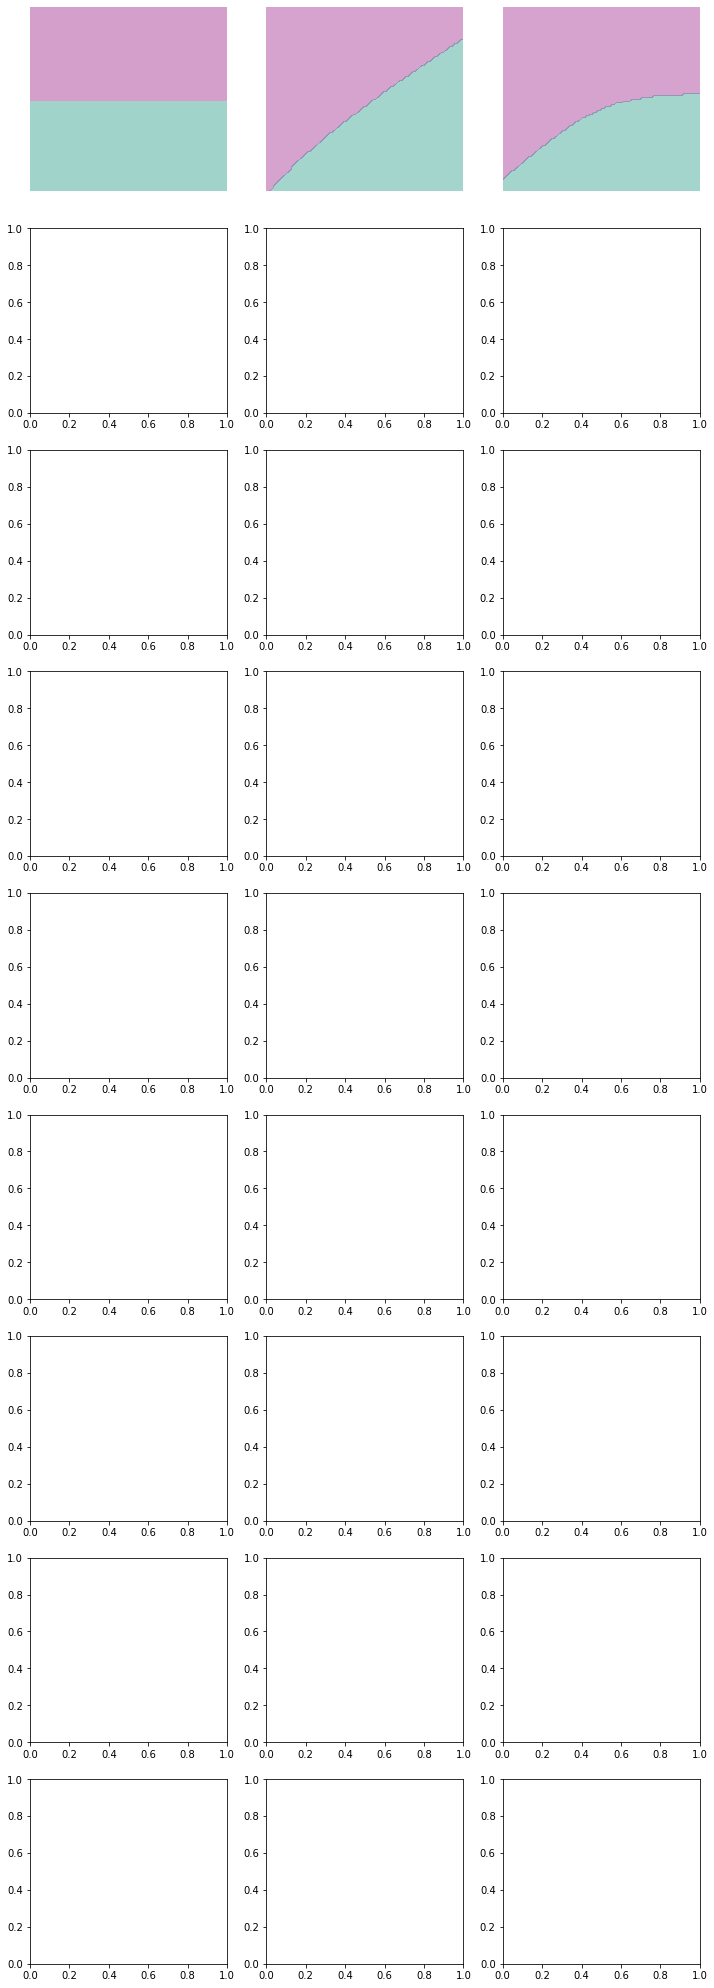

In [40]:
d, f = run_analyses(reps = 30, clfs = clfs, fname = 'NN_misaligned', makefig = True, resample_data = False, rotate = True)

In [84]:
# d, f = run_analyses(reps = 30, clfs = clfs, fname = 'make_noisy_100runs', makefig = False)

In [85]:
# d, f = run_analyses(reps = 200, clfs = clfs, fname = 'axis_aligned_200runs', makefig = False)

In [86]:
# d, f = run_analyses(reps = 200, clfs = clfs, fname = 'axis_misaligned_200runs', rotate = True, makefig = False)

## effect of fixed lengthscale

In [38]:
# without resampling data

clfs = [
    
    (gaussian_process.GaussianProcessClassifier(kernel = gpk.RBF(),
                                               max_iter_predict = 20), 'fitted_gauss_kernel'),
    
    (gaussian_process.GaussianProcessClassifier(kernel = gpk.RBF(length_scale = 0.1, length_scale_bounds = 'fixed'),
                                               max_iter_predict = 20), 'gauss_kernel_ls0.1'),
    
    (gaussian_process.GaussianProcessClassifier(kernel = gpk.RBF(length_scale = 0.5, length_scale_bounds = 'fixed'),
                                               max_iter_predict = 20), 'gauss_kernel_ls0.5'),
     
    (gaussian_process.GaussianProcessClassifier(kernel = gpk.RBF(length_scale = 2.0, length_scale_bounds = 'fixed'),
                                               max_iter_predict = 20), 'gauss_kernel_ls2'),
    
    (gaussian_process.GaussianProcessClassifier(kernel = gpk.RBF(length_scale = 4.0, length_scale_bounds = 'fixed'),
                                               max_iter_predict = 20), 'gauss_kernel_ls4'),
    
    (gaussian_process.GaussianProcessClassifier(kernel = gpk.RBF(length_scale = 6.0, length_scale_bounds = 'fixed'),
                                               max_iter_predict = 20), 'gauss_kernel_ls6'),
    
    (gaussian_process.GaussianProcessClassifier(kernel = gpk.RBF(length_scale = 8.0, length_scale_bounds = 'fixed'),
                                               max_iter_predict = 20), 'gauss_kernel_ls8'),
    
    (gaussian_process.GaussianProcessClassifier(kernel = gpk.RBF(length_scale = 10, length_scale_bounds = 'fixed'),
                                               max_iter_predict = 20), 'gauss_kernel_ls10'),
    
    (gaussian_process.GaussianProcessClassifier(kernel = gpk.RBF(length_scale = 100, length_scale_bounds = 'fixed'),
                                               max_iter_predict = 20), 'gauss_kernel_ls10'),


            ]



Getting new data
copy: 0
Getting new data
0 GaussianProcessClassifier(kernel=RBF(length_scale=1), max_iter_predict=20) conflict
0.6060606060606061
0 GaussianProcessClassifier(kernel=RBF(length_scale=1), max_iter_predict=20) zero_shot
1.0
0 GaussianProcessClassifier(kernel=RBF(length_scale=1), max_iter_predict=20) partial_exposure
0.7373737373737373
copy: 1
Getting new data
0.52
1.0
0.62
copy: 2
Getting new data
0.46
1.0
0.5
copy: 3
Getting new data
0.48
1.0
0.59
copy: 4
Getting new data
0.51
1.0
0.71
copy: 5
Getting new data
0.38
1.0
0.62
copy: 6
Getting new data
0.42
1.0
0.62
copy: 7
Getting new data
0.44
0.99
0.7
copy: 8
Getting new data
0.42574257425742573
0.9900990099009901
0.6039603960396039
copy: 9
Getting new data
0.49504950495049505
0.9900990099009901
0.6237623762376238
copy: 10
Getting new data
0.5346534653465347
1.0
0.6435643564356436
copy: 11
Getting new data
0.5151515151515151
1.0
0.6565656565656566
copy: 12
Getting new data
0.38
1.0
0.52
copy: 13
Getting new data
0.4901960

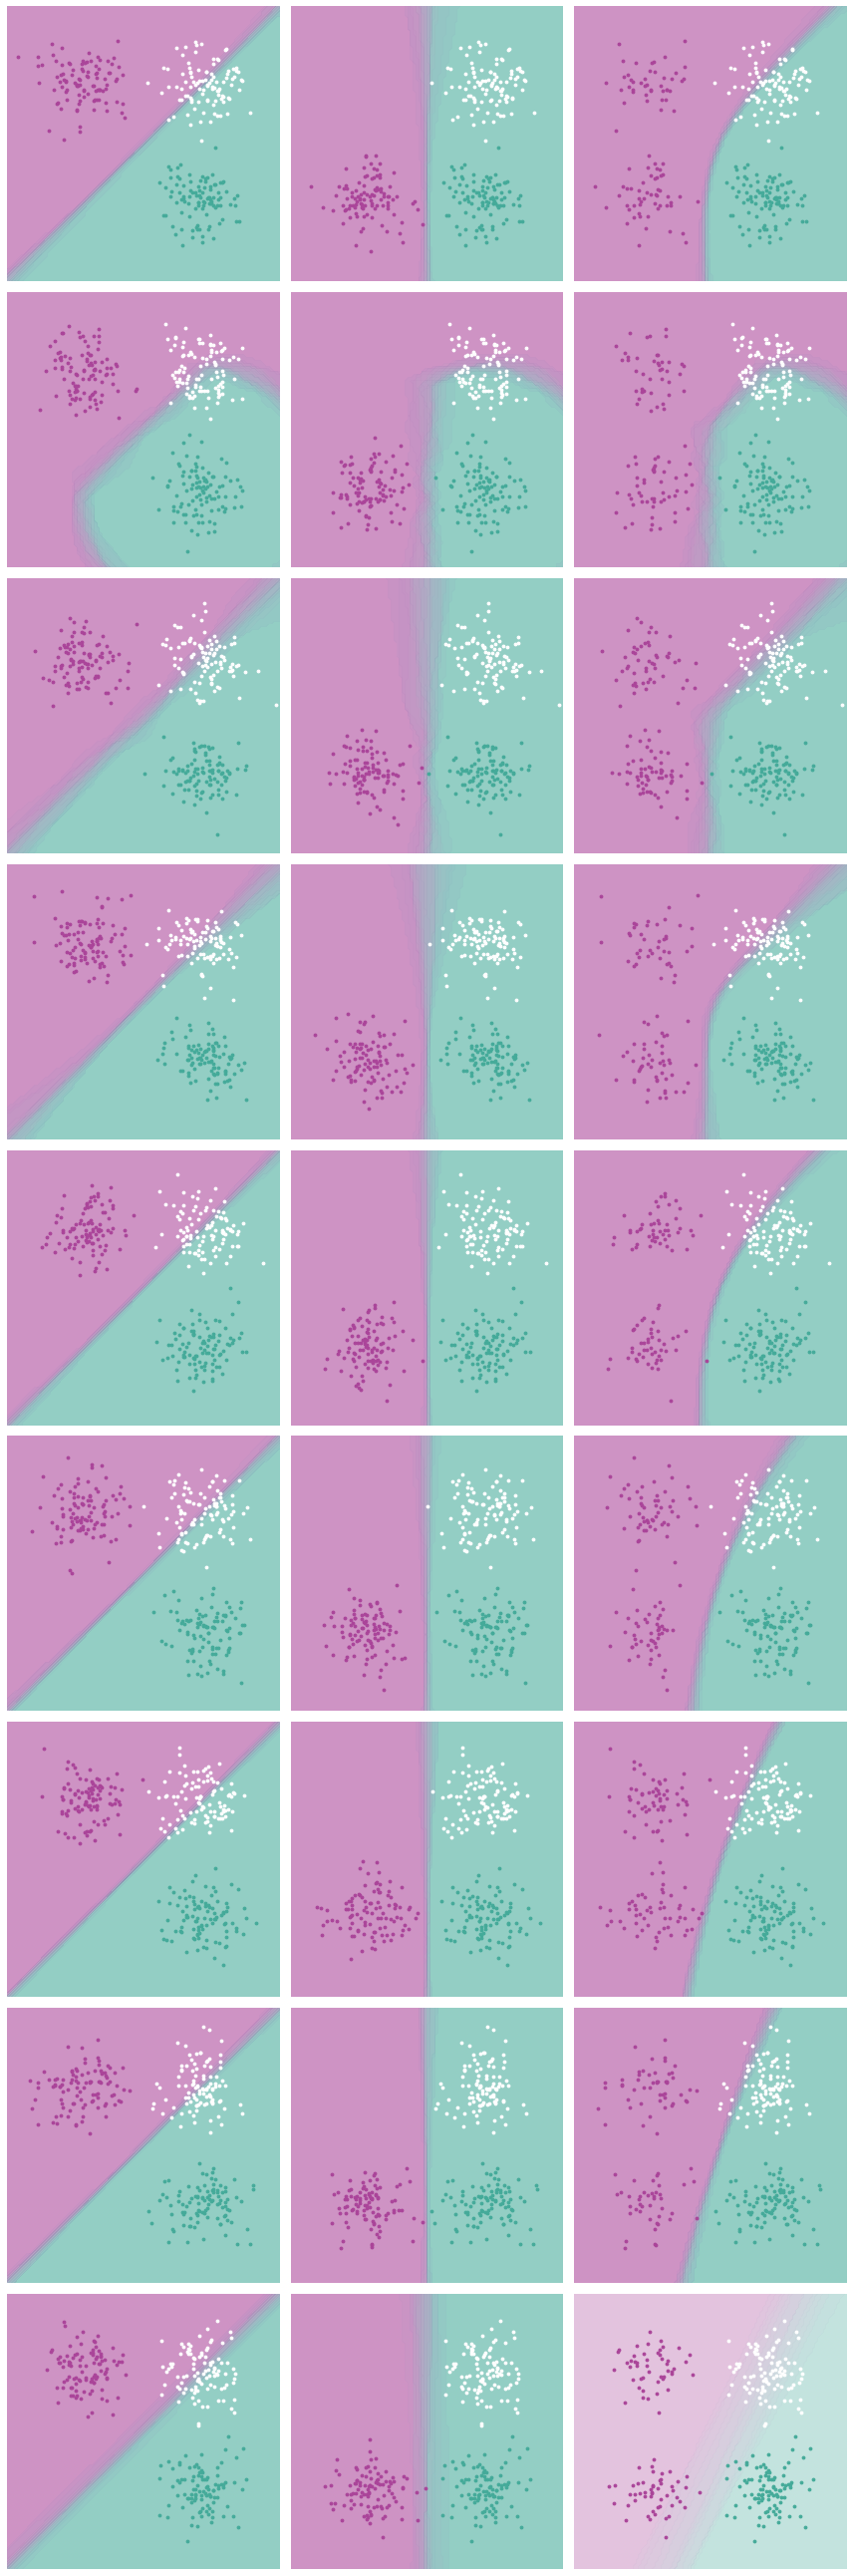

In [39]:
d, f = run_analyses(reps = 30, clfs = clfs, fname = 'RBF_lengthscale', makefig = True, resample_data = True)